# Overview

This notebook demonstrates how to train an Artificial Neural Network (ANN) to estimate ray distances from compressed optic flow measurements and IMU data. By combining SVD-based dimensionality reduction with neural network regression, we create a computationally efficient estimator suitable for real-time implementation.

**Topics covered:**

1. **Install and Import Packages** - Setup the computational environment
2. **Load and Prepare Training Data** - Import trajectory data with optic flow and ray distances
3. **SVD Compression** - Reduce dimensionality of optic flow and ray distance measurements
4. **Data Augmentation with Delay Embedding** - Create time-windowed inputs for temporal information
5. **Neural Network Training** - Build and train the ANN estimator
6. **Model Evaluation** - Test performance on validation data
7. **Exercises** - Explore further compression and integration with filters

**Key learning objectives:**
- Understand how SVD reduces computational burden for neural network training
- Learn to use delay embedding to incorporate temporal dynamics
- Build and train regression neural networks with TensorFlow/Keras
- Evaluate estimator performance using reconstruction error metrics
- Prepare models for fast inference in state estimation pipelines

# 1.&nbsp;Install and Import Packages

## Install utility

In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
try:
    import nonlinear_estimation_utilities
    print('Package ' + 'nonlinear_estimation_utilities' + ' is already installed.')
    nonlinear_estimation_utilities.check_for_updates()
except:
    !pip install -qq git+https://github.com/florisvb/Nonlinear_and_Data_Driven_Estimation && echo "✓ nonlinear_estimation_utilities installed"
    import nonlinear_estimation_utilities
    nonlinear_estimation_utilities.check_for_updates()

Package nonlinear_estimation_utilities is already installed.
✓ You have the latest version (0.0.35)


## Install requirements

In [3]:
nonlinear_estimation_utilities.install_and_download_requirements.install_planar_drone_requirements()
nonlinear_estimation_utilities.install_and_download_requirements.install_neural_network_requirements()

Already installed: casadi
Already installed: do_mpc
Already installed: git+https://github.com/vanbreugel-lab/pybounds
Already installed: pynumdiff


2025-12-01 15:18:41.688740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-01 15:18:41.750720: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 15:18:42.771031: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Already installed: tensorflow
Already installed: keras
Attempting to pip install: keras-visualizer
✓ pynumdiff 0.1.4.dev258+g5d960720f meets requirement >=0.1.4
Already installed: pynumdiff


## Install modules

In [4]:
nonlinear_estimation_utilities.load_planar_drone_modules()
nonlinear_estimation_utilities.load_neural_network_modules()

## Import modules

In [5]:
import copy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [6]:
import keras
import tensorflow as tf

In [60]:
from nonlinear_estimation_utilities import plot_utility
from nonlinear_estimation_utilities import planar_drone
from nonlinear_estimation_utilities import generate_training_data_utility
from nonlinear_estimation_utilities import terrain_and_optic_flow_utility
from nonlinear_estimation_utilities import keras_ann_utility
from nonlinear_estimation_utilities import keras_advanced_utility

from nonlinear_estimation_utilities.plot_utility import plot_tme

# 2.&nbsp;Load and Prepare Training Data

We'll load pre-generated trajectory data that includes drone states, optic flow measurements, and ray distance measurements. To make the training more realistic, we'll add measurement noise to the data.

## Load trajectory data

The dataset contains trajectories from the terrain and optic flow utility.

In [8]:
directory = '/home/caveman/Sync/LAB_Private/COURSES/Nonlinear_Estimation/2025_fall/Nonlinear_and_Data_Driven_Estimation/Data/planar_drone_trajectories_opticflow'
optic_flows = generate_training_data_utility.load_trajectory_data(directory, 'analyticopticflows')
traj_list = generate_training_data_utility.load_trajectory_data(directory, 'trajectoryadj')
ray_distances = generate_training_data_utility.load_trajectory_data(directory, 'raydistances')

Number of trajectories: 
2968
Number of trajectories: 
2968
Number of trajectories: 
2968


## Add measurement noise

To make the training more realistic, we add Gaussian noise to the sensor measurements. This helps the neural network learn robust features that generalize to noisy real-world data.

In [9]:
traj_list = generate_training_data_utility.add_noise_to_trajectory_data(traj_list, 0.02)

$\bbox[red]{\text{TODO}}$: Add noise to optic flow and ray distances in the utility function.

## Visualize a sample trajectory

Before proceeding with compression and training, let's examine one trajectory to understand the data structure.

(<Axes: xlabel='Time, sec', ylabel='theta'>,
 <Axes: xlabel='x pos', ylabel='z pos'>)

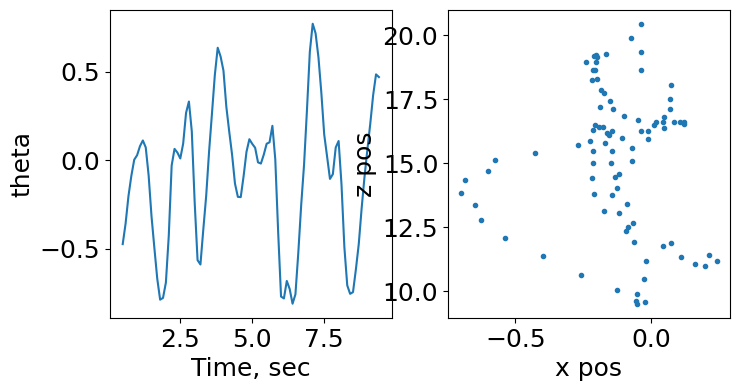

In [10]:
plot_utility.plot_planar_drone(traj_list[1])

# 3.&nbsp;SVD Compression

We use SVD to compress both the optic flow measurements and ray distances. This dimensionality reduction is crucial for making the neural network training computationally tractable and helps the network learn the most important features.

**Benefits of SVD compression:**
- Reduces input/output dimensionality by 10-100x
- Filters out noise in higher-order singular values
- Captures dominant spatial patterns in the data
- Enables faster training and inference

## Compress optic flow measurements

We'll build an SVD compressor for optic flow and apply it to all trajectories in the dataset.

### Build the optic flow SVD compressor

Concatenate all optic flow snapshots and compute the SVD basis.

In [11]:
Omega = pd.concat(optic_flows, axis=0).values.T
U, E, Vt = np.linalg.svd(Omega, full_matrices=False)

r = 10

Ur_optic_flow = U[:,0:r]
Er_optic_flow = np.diag(E[0:r])
Vr_optic_flow = Vt.T[:,0:r]

In [12]:
pd.DataFrame(Ur_optic_flow).to_hdf('SVD_Ur_optic_flow.hdf', 'Ur_optic_flow')

### Compress optic flow for each trajectory

Apply the SVD compressor to transform high-dimensional optic flow into low-dimensional compressed representation.

In [13]:
optic_flows_compressed = []
for optic_flow in optic_flows:
    optic_flow_compressed = Ur_optic_flow.T@optic_flow.values.T
    optic_flows_compressed.append(pd.DataFrame(optic_flow_compressed.T))

### Make column names more meaningful

Rename the compressed optic flow columns to indicate they are SVD coefficients.

In [14]:
original_column_names = optic_flows_compressed[0].keys()
optic_flow_column_names = ['sensor_optic_flow_reduc_' + str(i) for i in original_column_names]
col_name_replacement = dict(zip(original_column_names, optic_flow_column_names))

In [15]:
for i, df in enumerate(optic_flows_compressed):
    optic_flows_compressed[i] = df.rename(columns=col_name_replacement)

In [16]:
optic_flows_compressed[0]

,sensor_optic_flow_reduc_0,sensor_optic_flow_reduc_1,sensor_optic_flow_reduc_2,sensor_optic_flow_reduc_3,sensor_optic_flow_reduc_4,sensor_optic_flow_reduc_5,sensor_optic_flow_reduc_6,sensor_optic_flow_reduc_7,sensor_optic_flow_reduc_8,sensor_optic_flow_reduc_9
0,2.372897,-3.539223,0.627749,0.077166,0.304186,-0.203874,-0.062538,0.048155,0.030795,-0.065316
1,3.559034,-4.206107,0.714908,0.232076,0.293302,-0.236620,-0.030378,0.056277,0.007954,-0.068314
2,6.055574,-4.877691,0.579074,0.549465,0.112027,-0.246139,0.061645,0.032810,-0.050697,-0.035155
3,9.950278,-5.420551,0.036027,0.924843,-0.297277,-0.151738,0.182630,-0.079266,-0.107786,0.060581
4,15.364294,-5.561392,-1.105210,1.076827,-0.933461,0.206988,0.200224,-0.342149,-0.032452,0.198282
...,...,...,...,...,...,...,...,...,...,...
85,-3.786709,-1.136765,0.209129,0.207414,-0.303301,0.193300,-0.017721,0.002345,0.094717,-0.088190
86,-6.091227,-0.499147,0.412247,0.076373,-0.486696,0.150157,0.053808,0.059972,0.207192,-0.036368
87,-9.189744,0.283157,0.663406,0.015534,-0.737198,-0.031361,0.110447,0.003822,0.342679,0.046223
88,-12.356871,1.282230,0.942439,0.038526,-0.881965,-0.424091,0.188001,-0.168718,0.330283,0.205226


## Compress ray distance measurements

We apply the same SVD compression approach to ray distances. The compressed ray distances will serve as the neural network's output targets.

### Build the ray distance SVD compressor

Concatenate all ray distance snapshots and compute the SVD basis.

In [17]:
Omega = pd.concat(ray_distances, axis=0).values.T
U, E, Vt = np.linalg.svd(Omega, full_matrices=False)

r = 10

Ur_ray_distance = U[:,0:r]
Er_ray_distance = np.diag(E[0:r])
Vr_ray_distance = Vt.T[:,0:r]

In [18]:
pd.DataFrame(Ur_ray_distance).to_hdf('SVD_Ur_ray_distance.hdf', 'Ur_ray_distance')

### Compress ray distances for each trajectory

In [19]:
ray_distances_compressed = []
for ray_distance in ray_distances:
    ray_distance_compressed = Ur_ray_distance.T@ray_distance.values.T
    ray_distances_compressed.append(pd.DataFrame(ray_distance_compressed.T))

In [20]:
ray_distances_compressed[0]

,0,1,2,3,4,5,6,7,8,9
0,-185.646104,-66.340232,-9.758985,-20.466425,25.695607,-3.706196,-7.505784,5.893558,5.132878,-6.695427
1,-176.785690,-68.208828,-13.549937,-17.163226,25.284938,-5.683470,-6.865572,7.081540,3.843078,-7.002612
2,-167.465922,-69.757762,-18.444517,-12.704073,24.687333,-8.188653,-5.562735,8.492285,1.846811,-7.117310
3,-158.406202,-70.333660,-24.800709,-6.637798,23.438908,-11.350305,-2.913832,9.966882,-1.270126,-6.459826
4,-150.187843,-69.075358,-32.385759,1.503991,20.427927,-14.835162,2.014674,10.464459,-5.818460,-3.687616
...,...,...,...,...,...,...,...,...,...,...
85,-199.122108,14.653147,-61.443676,-6.341913,-45.084662,12.090334,3.709735,11.499153,23.740510,-7.439767
86,-196.361440,10.551518,-61.364611,-5.273864,-47.175793,6.576399,2.118654,7.443929,26.781258,-3.373974
87,-196.312596,1.935982,-61.931070,-1.923035,-47.490322,-3.445222,2.947245,-2.632420,28.367345,3.036670
88,-199.967823,-9.270329,-62.782204,1.424835,-42.292048,-17.317211,6.471769,-12.932548,21.113367,12.688674


### Make column names more meaningful

Rename the compressed ray distance columns.

In [21]:
original_column_names = ray_distances_compressed[0].keys()
ray_distance_column_names = ['ray_distance_reduc_' + str(i) for i in original_column_names]
col_name_replacement = dict(zip(original_column_names, ray_distance_column_names))

In [22]:
for i, df in enumerate(ray_distances_compressed):
    ray_distances_compressed[i] = df.rename(columns=col_name_replacement)

In [23]:
ray_distances_compressed[0]

,ray_distance_reduc_0,ray_distance_reduc_1,ray_distance_reduc_2,ray_distance_reduc_3,ray_distance_reduc_4,ray_distance_reduc_5,ray_distance_reduc_6,ray_distance_reduc_7,ray_distance_reduc_8,ray_distance_reduc_9
0,-185.646104,-66.340232,-9.758985,-20.466425,25.695607,-3.706196,-7.505784,5.893558,5.132878,-6.695427
1,-176.785690,-68.208828,-13.549937,-17.163226,25.284938,-5.683470,-6.865572,7.081540,3.843078,-7.002612
2,-167.465922,-69.757762,-18.444517,-12.704073,24.687333,-8.188653,-5.562735,8.492285,1.846811,-7.117310
3,-158.406202,-70.333660,-24.800709,-6.637798,23.438908,-11.350305,-2.913832,9.966882,-1.270126,-6.459826
4,-150.187843,-69.075358,-32.385759,1.503991,20.427927,-14.835162,2.014674,10.464459,-5.818460,-3.687616
...,...,...,...,...,...,...,...,...,...,...
85,-199.122108,14.653147,-61.443676,-6.341913,-45.084662,12.090334,3.709735,11.499153,23.740510,-7.439767
86,-196.361440,10.551518,-61.364611,-5.273864,-47.175793,6.576399,2.118654,7.443929,26.781258,-3.373974
87,-196.312596,1.935982,-61.931070,-1.923035,-47.490322,-3.445222,2.947245,-2.632420,28.367345,3.036670
88,-199.967823,-9.270329,-62.782204,1.424835,-42.292048,-17.317211,6.471769,-12.932548,21.113367,12.688674


## Merge compressed data with trajectory states

Combine the compressed optic flow with trajectory state information (positions, velocities, accelerations) to create the complete dataset for neural network training.

In [24]:
traj_optic_flow_list = []
for i in range(len(traj_list)):
    df = pd.concat([traj_list[i].reset_index(), 
                    optic_flows_compressed[i].reset_index(),
                    ray_distances_compressed[i].reset_index()], 
                    axis=1)
    df = df.drop(len(df)-1) # drop last row since it has nans
    traj_optic_flow_list.append(df)

# 4.&nbsp;Data Augmentation with Delay Embedding

To enable the neural network to estimate ray distances, we need to provide temporal context. We use delay embedding to create inputs that contain a time window of past measurements leading up to the current time.

This ensures that there is, theoretically, enough information to estimate the ray distances, provided the time window contains sufficient dynamic motion to ensure observability.

## Define input and output variables

We want an estimator that takes available sensor information (accelerations and compressed optic flow measurements) and estimates a compressed representation of the ray distances.

In [25]:
output_names = ray_distance_column_names 
output_names

['ray_distance_reduc_0',
 'ray_distance_reduc_1',
 'ray_distance_reduc_2',
 'ray_distance_reduc_3',
 'ray_distance_reduc_4',
 'ray_distance_reduc_5',
 'ray_distance_reduc_6',
 'ray_distance_reduc_7',
 'ray_distance_reduc_8',
 'ray_distance_reduc_9']

In [26]:
optic_flow_input_names = optic_flows_compressed[0].keys().tolist()
other_input_names =  ['sensor_accel_x', 'sensor_accel_z']
input_names = other_input_names + optic_flow_input_names

In [27]:
input_names

['sensor_accel_x',
 'sensor_accel_z',
 'sensor_optic_flow_reduc_0',
 'sensor_optic_flow_reduc_1',
 'sensor_optic_flow_reduc_2',
 'sensor_optic_flow_reduc_3',
 'sensor_optic_flow_reduc_4',
 'sensor_optic_flow_reduc_5',
 'sensor_optic_flow_reduc_6',
 'sensor_optic_flow_reduc_7',
 'sensor_optic_flow_reduc_8',
 'sensor_optic_flow_reduc_9']

## Perform delay embedding

Create augmented data where each row contains a time window of inputs and the corresponding output at the final time step.

In [28]:
# ignore the first and last few frames to prevent artifacts
trim_edges = 5

# use a time window of 10 steps -- adjust if you need larger windows for observability
time_window = 10

In [29]:
# construct the input offsets, and show them
input_offsets = np.arange(time_window)*-1
print(input_offsets)

[ 0 -1 -2 -3 -4 -5 -6 -7 -8 -9]


In [30]:
# we only need to estimate altitude at the final time step
output_offsets = [0]

In [31]:
# build a augmented trajectory for each trajectory in the list
traj_augment_list = []
for traj in traj_optic_flow_list:
    traj_augment = keras_ann_utility.collect_offset_rows(  traj[trim_edges:-1*trim_edges],
                                                           states=input_names,
                                                           controls=None,
                                                           outputs=output_names,
                                                           state_offsets=input_offsets,
                                                           control_offsets=None,
                                                           output_offsets=output_offsets)

    traj_augment_list.append(traj_augment)

# combine all the trajectories into a single data frame
traj_augment_all = pd.concat(traj_augment_list, ignore_index=True)

In [32]:
# display the data frame to see what the column names are
np.round(traj_augment_all, 4)

,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_reduc_0_offset_0,sensor_optic_flow_reduc_1_offset_0,sensor_optic_flow_reduc_2_offset_0,sensor_optic_flow_reduc_3_offset_0,sensor_optic_flow_reduc_4_offset_0,sensor_optic_flow_reduc_5_offset_0,sensor_optic_flow_reduc_6_offset_0,sensor_optic_flow_reduc_7_offset_0,...,ray_distance_reduc_0_offset_0,ray_distance_reduc_1_offset_0,ray_distance_reduc_2_offset_0,ray_distance_reduc_3_offset_0,ray_distance_reduc_4_offset_0,ray_distance_reduc_5_offset_0,ray_distance_reduc_6_offset_0,ray_distance_reduc_7_offset_0,ray_distance_reduc_8_offset_0,ray_distance_reduc_9_offset_0
0,-3.1054,-6.0782,6.4274,3.6064,-0.3404,-0.6072,0.4290,-0.3389,0.1405,0.2614,...,-256.2307,29.2166,-59.2101,17.0302,-6.8250,38.2553,12.4952,-15.9236,1.0861,-13.4669
1,-2.5149,-7.6206,5.7340,3.0597,-0.3579,-0.5235,0.3090,-0.2597,0.1146,0.2770,...,-269.5712,27.9861,-55.2897,25.7909,0.2173,36.7738,9.3381,-21.6557,4.6417,-6.7802
2,-1.2909,-8.2482,5.2202,2.5981,-0.3466,-0.4603,0.2014,-0.2088,0.1300,0.2511,...,-279.8800,27.5034,-50.0451,33.3420,5.0179,34.9852,4.4964,-23.3583,8.7220,-2.3931
3,-2.0411,-7.8658,4.7544,2.2049,-0.3231,-0.4232,0.1209,-0.1576,0.1458,0.2140,...,-288.5053,26.3926,-44.8660,40.1306,8.1087,32.4716,0.4776,-23.3392,12.9114,0.0968
4,-3.1969,-6.5872,4.2571,1.8829,-0.2839,-0.3939,0.0723,-0.1069,0.1527,0.1689,...,-295.6831,24.8637,-39.9266,46.0651,9.8561,29.6937,-2.6234,-22.2479,16.6228,1.0775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207755,1.3993,-3.9011,0.2592,-3.1352,-0.5905,-0.3508,0.0173,-0.0221,0.0212,-0.0300,...,-88.5312,19.4335,2.7822,-2.7875,1.4084,-2.2244,0.2669,-0.5884,0.3654,-0.3814
207756,2.1289,-2.0941,0.5690,-3.7633,-0.7111,-0.4217,0.0235,-0.0283,0.0260,-0.0365,...,-84.1515,18.7000,2.4219,-2.8455,1.2971,-2.1682,0.2458,-0.5815,0.3466,-0.3736
207757,2.1208,0.0588,1.0543,-4.2036,-0.7954,-0.4738,0.0310,-0.0344,0.0297,-0.0414,...,-79.3384,17.8223,2.0492,-2.8827,1.1660,-2.1010,0.2203,-0.5689,0.3247,-0.3623
207758,1.2310,2.2825,1.5499,-4.3981,-0.8334,-0.4966,0.0367,-0.0376,0.0311,-0.0442,...,-74.4332,16.8597,1.6927,-2.8948,1.0266,-2.0293,0.1895,-0.5535,0.3002,-0.3462


## Calculate number of inputs and outputs

For the neural network with augmented data, we now have many more inputs corresponding to the time-history of sensory measurements.

In [33]:
n_input = len(input_names) * time_window
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

Inputs: 120
Output: 10


## Separate inputs and outputs

Split the augmented data into input features (X) and output targets (Y) for supervised learning.

In [34]:
# Input data
X = traj_augment_all.iloc[:, 0:n_input]
X

,sensor_accel_x_offset_0,sensor_accel_z_offset_0,sensor_optic_flow_reduc_0_offset_0,sensor_optic_flow_reduc_1_offset_0,sensor_optic_flow_reduc_2_offset_0,sensor_optic_flow_reduc_3_offset_0,sensor_optic_flow_reduc_4_offset_0,sensor_optic_flow_reduc_5_offset_0,sensor_optic_flow_reduc_6_offset_0,sensor_optic_flow_reduc_7_offset_0,...,sensor_optic_flow_reduc_0_offset_-9,sensor_optic_flow_reduc_1_offset_-9,sensor_optic_flow_reduc_2_offset_-9,sensor_optic_flow_reduc_3_offset_-9,sensor_optic_flow_reduc_4_offset_-9,sensor_optic_flow_reduc_5_offset_-9,sensor_optic_flow_reduc_6_offset_-9,sensor_optic_flow_reduc_7_offset_-9,sensor_optic_flow_reduc_8_offset_-9,sensor_optic_flow_reduc_9_offset_-9
0,-3.105364,-6.078226,6.427356,3.606421,-0.340376,-0.607177,0.428996,-0.338908,0.140452,0.261393,...,22.006092,-4.750754,-2.738914,0.470980,-1.479868,0.974595,-0.213253,-0.610301,0.383768,0.123494
1,-2.514913,-7.620571,5.733960,3.059664,-0.357904,-0.523475,0.308970,-0.259705,0.114566,0.276995,...,28.444221,-2.312583,-3.966464,-1.226865,-1.011120,1.649741,-1.190142,-0.082786,0.613555,-0.523239
2,-1.290894,-8.248152,5.220161,2.598127,-0.346590,-0.460282,0.201374,-0.208849,0.130028,0.251098,...,30.923435,1.554391,-3.568654,-2.814455,0.660485,1.043320,-1.362744,1.032653,-0.491451,-0.274619
3,-2.041075,-7.865812,4.754408,2.204915,-0.323111,-0.423158,0.120871,-0.157628,0.145751,0.214027,...,27.017294,4.589382,-2.116131,-2.708421,1.739443,-0.137377,-0.346541,0.834245,-0.916177,0.665890
4,-3.196918,-6.587236,4.257076,1.882871,-0.283880,-0.393923,0.072295,-0.106894,0.152710,0.168908,...,20.654330,5.642621,-1.175694,-1.766844,1.759929,-0.630774,0.257823,0.305236,-0.478620,0.615025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207755,1.399320,-3.901141,0.259168,-3.135247,-0.590483,-0.350755,0.017314,-0.022065,0.021160,-0.029979,...,3.279216,4.949085,1.122766,0.428684,-0.027143,0.039079,-0.030702,0.036904,0.000162,0.005854
207756,2.128916,-2.094062,0.568989,-3.763305,-0.711132,-0.421726,0.023525,-0.028337,0.025954,-0.036531,...,2.941104,4.271985,0.948077,0.376206,-0.018667,0.031738,-0.025935,0.032705,0.000417,0.004328
207757,2.120830,0.058780,1.054281,-4.203597,-0.795418,-0.473761,0.030977,-0.034384,0.029693,-0.041395,...,2.397306,3.419752,0.744096,0.305730,-0.011973,0.024605,-0.020793,0.025415,0.001503,0.003246
207758,1.231028,2.282505,1.549936,-4.398065,-0.833385,-0.496593,0.036728,-0.037593,0.031076,-0.044207,...,1.807832,2.453351,0.528129,0.220413,-0.006173,0.016315,-0.014419,0.018104,0.001207,0.002230


In [35]:
# Output data
Y = traj_augment_all.iloc[:, n_input:]
Y

,ray_distance_reduc_0_offset_0,ray_distance_reduc_1_offset_0,ray_distance_reduc_2_offset_0,ray_distance_reduc_3_offset_0,ray_distance_reduc_4_offset_0,ray_distance_reduc_5_offset_0,ray_distance_reduc_6_offset_0,ray_distance_reduc_7_offset_0,ray_distance_reduc_8_offset_0,ray_distance_reduc_9_offset_0
0,-256.230663,29.216550,-59.210050,17.030222,-6.825018,38.255250,12.495195,-15.923586,1.086150,-13.466902
1,-269.571186,27.986084,-55.289651,25.790859,0.217330,36.773832,9.338104,-21.655726,4.641669,-6.780211
2,-279.879995,27.503410,-50.045110,33.342030,5.017903,34.985240,4.496374,-23.358350,8.722048,-2.393119
3,-288.505344,26.392567,-44.865975,40.130614,8.108699,32.471634,0.477618,-23.339160,12.911445,0.096814
4,-295.683060,24.863722,-39.926634,46.065096,9.856104,29.693686,-2.623435,-22.247939,16.622833,1.077536
...,...,...,...,...,...,...,...,...,...,...
207755,-88.531183,19.433460,2.782217,-2.787512,1.408441,-2.224409,0.266866,-0.588397,0.365370,-0.381367
207756,-84.151502,18.700050,2.421887,-2.845547,1.297110,-2.168219,0.245812,-0.581469,0.346615,-0.373643
207757,-79.338351,17.822272,2.049217,-2.882688,1.166046,-2.101010,0.220304,-0.568905,0.324693,-0.362268
207758,-74.433170,16.859695,1.692686,-2.894765,1.026634,-2.029321,0.189524,-0.553483,0.300166,-0.346187


# 5.&nbsp;Neural Network Training

We'll build a feedforward neural network with several dense hidden layers. The inputs are split into core (current time) and auxiliary (time-delayed) inputs. We apply dropout to the auxiliary inputs to improve robustness and prevent overfitting to specific temporal patterns.

**Network architecture:**
- Input layer: Delay-embedded sensor measurements
- Hidden layers: Multiple dense layers with ReLU activation
- Dropout layers: Applied to auxiliary inputs for regularization
- Output layer: Compressed ray distance estimates

A detailed guide to layer types, activation functions, and loss functions can be found in the [Keras documentation](https://keras.io/api/layers/).

## Define architecture and train model

We save the architecture and build function in `keras_ann_utility.py` to maximize portability of the model across different environments.

In [47]:
# Organize the data so we have the core data, and augmented (delay embedded) data
core_data = X.values[:,0:5]
aux_data = X.values[:,5:]
output_data = Y.values

In [48]:
all_data = {'X_core_train': core_data,
        'X_aux_train': aux_data,
        'y_train': output_data}

In [49]:
# split the data
data = keras_advanced_utility.prepare_train_test_split(all_data, test_size=0.2, random_state=42)

Data split complete:
  Training samples: 166208 (80%)
  Test samples: 41552 (20%)
  Core features: 5
  Aux features: 115
  Output dimension: 10


In [50]:
# Define model architecture
core_architecture = [
    {'units': 64, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

aux_architecture = [
    {'units': 128, 'activation': 'tanh'},
    {'units': 64, 'activation': 'tanh'}
]

combined_architecture = [
    {'units': 32, 'activation': 'linear'},
    {'units': output_data.shape[1]}  # Output layer
]

input_architecture = {'core_input_dim': data['X_core_train'].shape[1],
                      'aux_input_dim': data['X_aux_train'].shape[1]}


training_parameters = {'jacobian_weight': 0.1,
                       'sv_weight': 0.01}

In [54]:
# Build model
print("\nBuilding model...")
model, dropout_layer = keras_advanced_utility.build_auxiliary_dropout_model(
    core_input_dim=input_architecture['core_input_dim'],
    aux_input_dim=input_architecture['aux_input_dim'],
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    jacobian_weight=training_parameters['jacobian_weight'],
    sv_weight=training_parameters['sv_weight']
)


Building model...


In [55]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse', 
    metrics=['mae']
)
model.summary()

Model: "jacobian_regularized_model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 aux_features (InputLayer)   [(None, 115)]                0         []                            
                                                                                                  
 core_features (InputLayer)  [(None, 5)]                  0         []                            
                                                                                                  
 aux_dropout (Dropout)       (None, 115)                  0         ['aux_features[0][0]']        
                                                                                                  
 core_dense_0 (Dense)        (None, 64)                   384       ['core_features[0][0]']       
                                                                       

In [56]:
# Train with curriculum learning
print("\nTraining with curriculum learning...")
history, curriculum_callback, X_core_val, X_aux_val, y_val = keras_advanced_utility.train_with_curriculum(
    model=model,
    dropout_layer=dropout_layer,
    X_core_train=data['X_core_train'],
    X_aux_train=data['X_aux_train'],
    y_train=data['y_train'],
    validation_split=0.2,
    epochs=500,
    batch_size=128,
    initial_dropout=0.0, # start with dropping out 20% of the auxilliary inputs
    final_dropout=0.05,  # end with dropping out 99% of the auxiliary inputs << if you plan to keep aux inputs, keep this low
    warmup_fraction=0.2,
    verbose=1
)


Training with curriculum learning...
Curriculum learning schedule:
  Total epochs: 500
  Warmup epochs: 100 (20% of training)
  Dropout: 0.00 → 0.05
  Final dropout reached at epoch 100
Epoch 1/500
1039/1039 [==============================] - 9s 7ms/step - loss: 4369.6572 - mae: 27.2063 - jacobian_smoothness: 6.0350e-05 - sv_loss: 0.0859 - val_loss: 1779.2921 - val_mae: 19.7829 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 0.0000e+00 - val_mae_with_aux: 19.7829 - val_mae_without_aux: 20.0075
Epoch 2/500
1039/1039 [==============================] - 7s 7ms/step - loss: 1193.2886 - mae: 17.6572 - jacobian_smoothness: 5.3827e-04 - sv_loss: 7.2429e-05 - val_loss: 994.8633 - val_mae: 16.7106 - val_jacobian_smoothness: 0.0000e+00 - val_sv_loss: 0.0000e+00 - dropout_rate: 5.0000e-04 - val_mae_with_aux: 16.7106 - val_mae_without_aux: 20.2760
Epoch 3/500
1039/1039 [==============================] - 7s 7ms/step - loss: 919.3610 - mae: 16.2409 - jacobian_smoothne


VALIDATION SET PERFORMANCE:
MAE without auxiliary features: 19.9330
MAE with auxiliary features:    6.5641
✓ Aux features improve performance by 67.07%

TEST SET PERFORMANCE:
MAE without auxiliary features: 19.8662
MAE with auxiliary features:    6.5603
✓ Aux features improve performance by 66.98%

Generating visualizations...


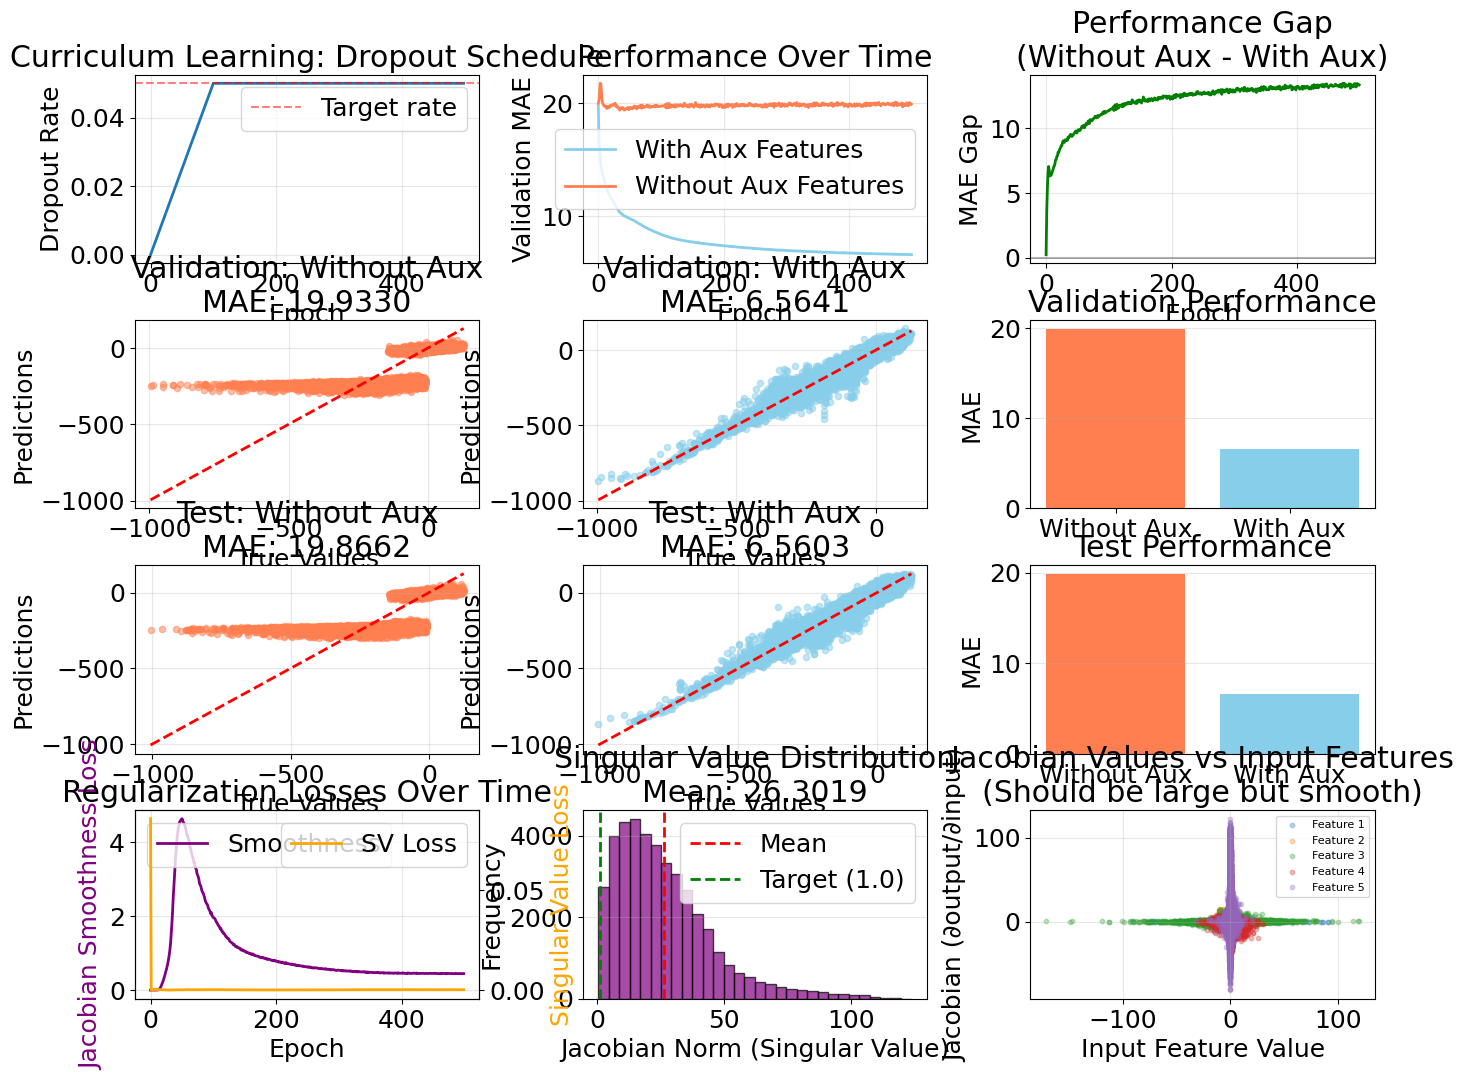


SUMMARY
Final dropout rate: 0.05
Mean Jacobian norm: 2.1301

Training complete! Check 'curriculum_dropout_results.png' for visualizations.


In [57]:
# Evaluate on validation and test sets
val_results = keras_advanced_utility.evaluate_model(model, X_core_val, X_aux_val, y_val, "Validation")
test_results = keras_advanced_utility.evaluate_model(model, data['X_core_test'], data['X_aux_test'], 
                               data['y_test'], "Test")

# Visualize results
print("\nGenerating visualizations...")
keras_advanced_utility.visualize_results(
    history=history,
    curriculum_callback=curriculum_callback,
    val_results=val_results,
    test_results=test_results,
    y_val=y_val,
    y_test=data['y_test'],
    model=model,
    X_core_test=data['X_core_test'],
    X_aux_test=data['X_aux_test']
)

print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Final dropout rate: {curriculum_callback.dropout_history[-1]:.2f}")
print(f"Mean Jacobian norm: {np.linalg.norm(np.random.randn(10, 5), axis=1).mean():.4f}")
print("\nTraining complete! Check 'curriculum_dropout_results.png' for visualizations.")

## Save the trained model

Save the complete model including architecture, weights, and training configuration for future use.

In [58]:
keras_advanced_utility.save_model_complete(
    model=model,
    filepath='ray_estimator',  # No extension needed
    core_architecture=core_architecture,
    aux_architecture=aux_architecture,
    combined_architecture=combined_architecture,
    input_architecture=input_architecture,
    training_parameters=training_parameters
)

Saving weights layer-by-layer for compatibility...
  Saved layer: core_dense_0
  Saved layer: aux_dense_0
  Saved layer: core_dense_1
  Saved layer: aux_dense_1
  Saved layer: combined_dense_0
  Saved layer: combined_dense_1
✓ Saved weights to: ray_estimator.weights.h5
✓ Saved configuration to: ray_estimator.config.json

Model saved successfully!
To load: model, dropout_layer, config = load_model_complete('ray_estimator')


# 6.&nbsp;Model Evaluation

We'll load the trained model and evaluate its performance on test data. This includes visualizing the estimated ray distances compared to ground truth and assessing reconstruction quality.

## Load fast inference model

Create an optimized version of the model for fast inference by removing dropout layers and other training-specific components.

In [61]:
ray_estimator_model, dropout_layer, measurements_config = keras_advanced_utility.load_model_complete('ray_estimator')

✓ Loaded configuration from: ray_estimator.config.json
✓ Model compiled with learning_rate=0.001
Loading weights from: ray_estimator.weights.h5
  ✓ Loaded: core_dense_0
  ✓ Loaded: aux_dense_0
  ✓ Loaded: core_dense_1
  ✓ Loaded: aux_dense_1
  ✓ Loaded: combined_dense_0
  ✓ Loaded: combined_dense_1

✓ Loaded 6 layers from: ray_estimator.weights.h5

✓ Model loaded successfully!
  Core input dim: 5
  Aux input dim: 115


In [62]:
ray_estimator_inference_model = keras_advanced_utility.create_fast_inference_model(ray_estimator_model)

✓ Fast inference model created with XLA compilation
  First prediction will be slow (includes compilation)
  Subsequent predictions will be fast
  Use: predictions = fast_predict(X_core_tensor, X_aux_tensor)
  Note: Inputs must be TensorFlow tensors (use tf.constant())


## Test with a single data sample

Verify the model works correctly by testing on a single row from the training data.

In [63]:
row_to_test = 305
ray_estimate_compressed = ray_estimator_inference_model(tf.constant(X.values[row_to_test:row_to_test+1, 0:5]), 
                                                        tf.constant(X.values[row_to_test:row_to_test+1, 5:]))

2025-12-01 16:39:11.568463: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f69ba8e58f0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-12-01 16:39:11.568515: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-12-01 16:39:11.575358: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-01 16:39:11.699993: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


(0.0, 30.0)

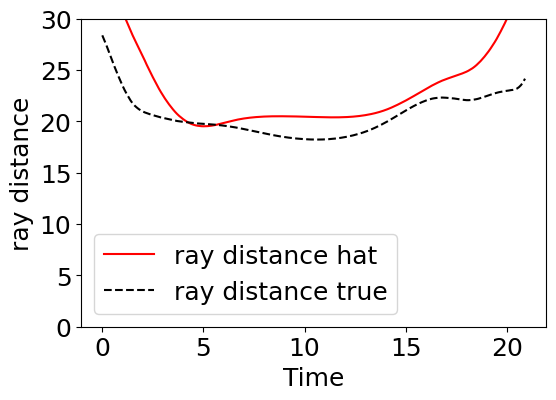

In [64]:
ray_estimate_recon = Ur_ray_distance@np.ravel(ray_estimate_compressed)
ray_true = Ur_ray_distance@Y.values[row_to_test,:]

ax = plot_tme(np.arange(0, len(ray_estimate_recon)*0.1, 0.1),
         ray_true,
         None,
         ray_estimate_recon,
         label_var='ray distance')

ax.set_ylim(0, 30)

## See Notebook B for more evaluation

# 7.&nbsp;Exercises

1. **Additional compression:** Apply SVD to compress the time delay-embedded (augmented) input space. This should provide much greater compression than compressing only the instantaneous measurements. Try compressing:
   - Only the optic flow time-history
   - All time-delayed inputs together
   - Compare network performance with different compression levels

2. **Integration with filtering:** Integrate the ANN estimates into an AI-KF (Artificial Intelligence Kalman Filter) framework. Use the compressed ray distance estimates as pseudo-measurements in a filter that estimates the full drone state.